# Data Understanding

This notebook is a proof-of-concept on finding out the exact specifications of the data that we wish to operate on. This step has several goals:
- Find out the data specification
- Find the best data representation for our deep learning model
- ???.

## Constants

| Constants            | Value |
|----------------------|---     |
| Sample rate          | 8000 |
| Image height         | 500|
| Image width (window) | 157   |
| Window length        | SAMPLE_RATE * 10 |

In [1]:
import os

# CONSTANTS
DATASET_DIR = '../data'
SAMPLE_RATE = 16000 # 8 kHz sample rate; we downsample because we want 4KHz — making the model more robust against noise in the higher frequencies.
IMAGE_HEIGHT = 500
IMAGE_WIDTH = 157
SPLIT_SECOND = 10 # second
WAVE_SAMPLE_LENGTH = int(SAMPLE_RATE * 0.25)
SAMPLE_LENGTH = SAMPLE_RATE * SPLIT_SECOND

## Dialects

Per the dialects retrieved from Max Planck Institute's EVA Jakarta Field Station, we have these dialects:
- Ngadas
- Banten
- Tengger
- Semarang
- Madiun
- Tegal
- Banyumas
- Papua
- Lumajang
- Solo
- Pemalang
- Cirebon
- Kediri
- Malang
- Osing
- Ranu Pane

In [2]:
dialects = os.listdir('../data/audio/')
dialects

['Ngadas',
 'Banten',
 'Tengger',
 'Semarang',
 'Madiun',
 'Tegal',
 'Banyumas',
 'Papua',
 'Lumajang',
 'Solo',
 'Pemalang',
 'Cirebon',
 'Kediri',
 'Malang',
 'Osing',
 'Ranu Pane']

## Audio Loading

In [3]:
from pathlib import Path

wavs = dict()
for dialect in dialects:
    wavs[dialect] = [wav for wav in os.listdir(Path('../data/audio') / dialect) if wav[-3:] == 'wav']

wavs

{'Ngadas': ['Marsam.wav', 'Mas_Tom_Ngadas_201102.wav'],
 'Banten': ['JWBP-20121229-A.wav',
  'JWBA-20100703-a.wav',
  'JWB-Banten_9.wav',
  'banten-2010-07-02-a.wav',
  'JWB-20090125.wav',
  'JWBP-20121229-B.wav',
  'JWB-Banten_10.wav',
  'JWB-20090126.wav',
  'JWB-20090116.wav',
  'JWB-Banten20100605-B.wav',
  'JWB-Banten_1.wav',
  'JWB-Banten_6.wav',
  'JWBA-20100703-b.wav',
  'JWB-Banten_4.wav',
  'JWB-20090117.wav',
  'JWB-20090118.wav',
  'JWB-Banten_8.wav',
  'JWB-20090131.wav',
  'JWB-20090130.wav',
  'JWB-Banten_11.wav',
  'JWB-Banten_5.wav',
  'JWB-20090123.wav',
  'JWB-20090124.wav',
  'JWB-20090127.wav',
  'JWB-Banten_19.wav',
  'JWB-Banten20100605-A.wav',
  'JWB-Banten_7.wav',
  'JWB-Banten_3.wav',
  'JWB-Banten_2.wav',
  'JWB-20090120.wav',
  'JWB-20090122.wav',
  'JWB-20070129.wav',
  'JWBS-20100702-b.wav'],
 'Tengger': ['Ngadisari.wav', 'Wonokitri.wav'],
 'Semarang': ['JCM-20080114.wav', 'JCM-20080115.wav'],
 'Madiun': ['Madiun.wav',
  'Madiun-20080125-Marpuah.wav',
  'J

In [4]:
# Loading our example audio
import librosa

_ = librosa.load(
    "../data/audio/Ngadas/Mas_Tom_Ngadas_201102.wav",
    sr=SAMPLE_RATE,
    mono=True,
    res_type='soxr_vhq'
)[0]
_segment = _[SAMPLE_LENGTH:SAMPLE_LENGTH + SAMPLE_LENGTH]

In [5]:
print(_segment)
print(_segment.shape)

[ 0.00366144  0.01288834  0.01554883 ... -0.00289218  0.00031064
  0.00213397]
(160000,)


## Waveform

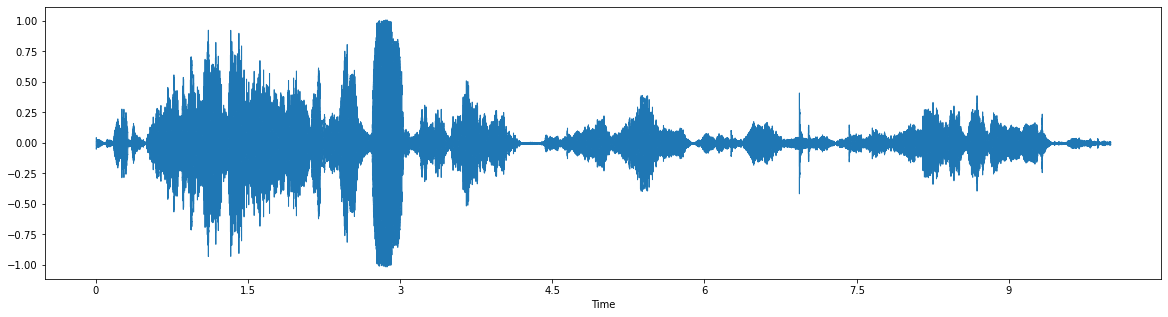

In [6]:
from matplotlib import pyplot as plt
from librosa import display

plt.figure(figsize=(20,5))
librosa.display.waveshow(_segment, sr=SAMPLE_RATE)
plt.savefig('../visualization/_segment.png')
plt.show()

## Pre-emphasis

/tmp/ipykernel_22877/1047569282.py:7: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(_segment_emphasized, SAMPLE_RATE)


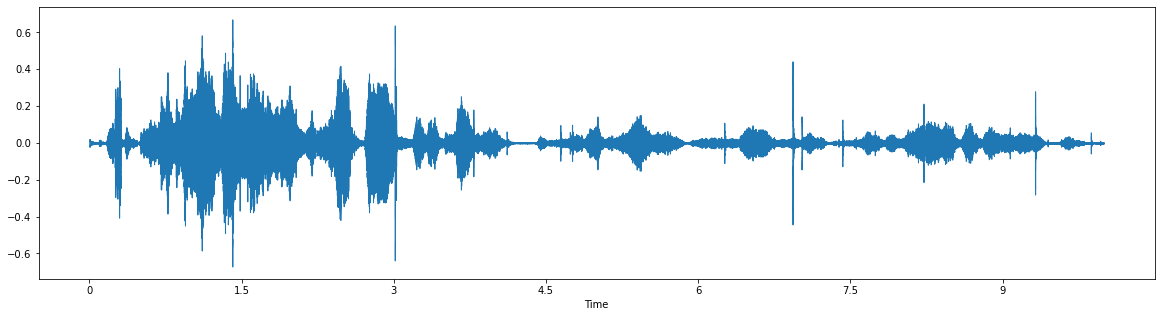

In [7]:
import numpy as np

PRE_EMPHASIS_ALPHA = 0.97
_segment_emphasized = np.append(_segment[0], _segment[1:] - PRE_EMPHASIS_ALPHA * _segment[:-1])

plt.figure(figsize=(20,5))
librosa.display.waveshow(_segment_emphasized, SAMPLE_RATE)
plt.savefig('../visualization/_segment_emphasized.png')
plt.show()

In [8]:
from scipy.io import wavfile

wavfile.write('../data/Mas_Tom_Ngadas_201102-segment.wav', SAMPLE_RATE, _segment)
wavfile.write('../data/Mas_Tom_Ngadas_201102-segment-emphasized.wav', SAMPLE_RATE, _segment_emphasized)

In [9]:
_emphasized = np.append(_[0], _[1:] - PRE_EMPHASIS_ALPHA * _[:-1])

# Setting emphasized as default?
_segment = _segment_emphasized
_ = _emphasized

## Voice Activity Detection

In [10]:
import numpy as np

def voice_activity_detection(input, feature=None):
    if feature is not None:
        frame_length = FRAME_SIZE_SAMPLE
        hop_length = FRAME_STRIDE_SAMPLE
    else:
        frame_length = 1
        hop_length = 1
    _rmse = librosa.feature.rms(input, frame_length=frame_length, hop_length=hop_length)
    _threshold = np.mean(_rmse) / 2 * 1.04  # credits to Shon et al. (2018)
    _mask = np.nonzero(_rmse > _threshold)[1]
    if feature is not None:
        return input[:, _mask]
    return input[_mask]

In [11]:
import numpy as np

# Voice Activity Detection - courtesy of Shon et al., (2018)
_segment_rmse = librosa.feature.rms(_segment, frame_length=1, hop_length=1)
_segment_threshold = np.mean(_segment_rmse) / 2 * 1.04
# _segment_vad_segments = np.nonzero(_segment_rmse > _segment_threshold)
_segment_mask = _segment_rmse > _segment_threshold

/tmp/ipykernel_22877/4233636282.py:4: FutureWarning: Pass y=[0.00366144 0.00933674 0.00304715 ... 0.00051035 0.00311605 0.00183265] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  _segment_rmse = librosa.feature.rms(_segment, frame_length=1, hop_length=1)


In [12]:
print(_segment_rmse > _segment_threshold)

[[False False False ... False False False]]


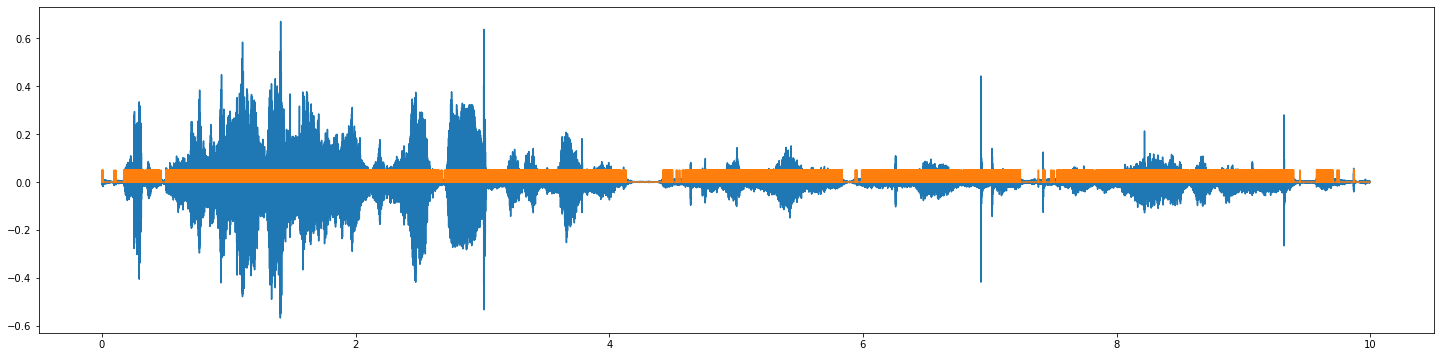

In [13]:
# Visualization
t = np.linspace(
    0,
    _segment.shape[0] / SAMPLE_RATE,
    _segment.shape[0])
plt.figure(figsize=(25, 6))
plt.plot(t, _segment)
plt.plot(t, [0.05 if d else 0 for d in _segment_mask[0]])
plt.savefig('../visualization/_segment_vad.svg')
plt.show()

/tmp/ipykernel_22877/3655426164.py:10: FutureWarning: Pass y=[0.00366144 0.00933674 0.00304715 ... 0.00051035 0.00311605 0.00183265] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  _rmse = librosa.feature.rms(input, frame_length=frame_length, hop_length=hop_length)


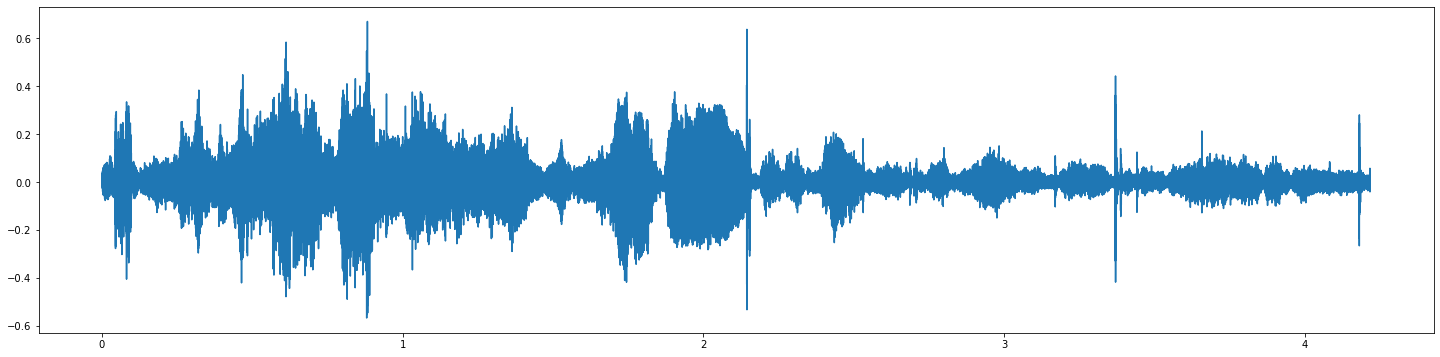

In [14]:
_segment_desilenced = voice_activity_detection(_segment, feature=None)
t_desilenced = np.linspace(
    0, 
    _segment_desilenced.shape[0] / SAMPLE_RATE,
    _segment_desilenced.shape[0]
) 

plt.figure(figsize=(25, 6))
plt.plot(t_desilenced, _segment_desilenced)
plt.show()

In [15]:
_desilenced = voice_activity_detection(_, feature=None)

/tmp/ipykernel_22877/3655426164.py:10: FutureWarning: Pass y=[ 0.0026103  -0.00595774  0.00753117 ... -0.00021945  0.00035524
 -0.00209893] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  _rmse = librosa.feature.rms(input, frame_length=frame_length, hop_length=hop_length)


## Frequency filtering

### Low-pass filter (Butter)
- Sample period: 25ms
- Sample rate: SAMPLE_RATE (16kHz)
- Total samples: 0.025 seconds * 16 kHz = 400 (sec * 1/sec)
- Signal frequency cutoff: 4 kHz
- Nyquist Frequency: SAMPLE_RATE/2 = 8 kHz
- Order: adjusting (ideal: 6?)

In [16]:
# Creating a low-pass filter up to 4 kHz
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=2):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

order = 6
fs = SAMPLE_RATE
cutoff = 4000
nyquist = 0.5 * fs

b, a = butter_lowpass(cutoff, fs, order)

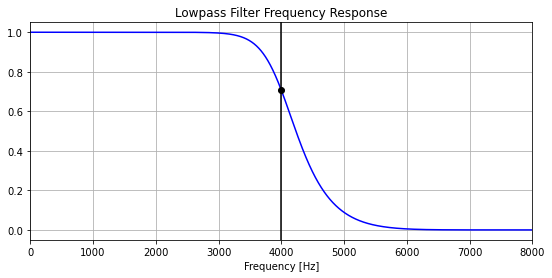

In [17]:
w, h = freqz(b, a, worN=8000)
plt.figure(figsize=(9, 4))
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, nyquist)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.savefig('../visualization/butter_lowpass_filter.png')
plt.show()

In [18]:
b

array([0.02958822, 0.17752934, 0.44382335, 0.59176447, 0.44382335,
       0.17752934, 0.02958822])

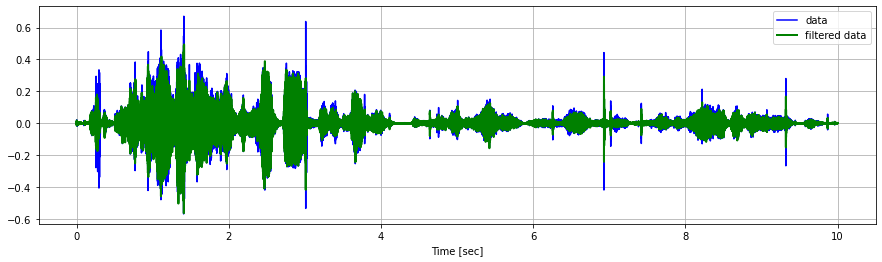

In [19]:
_segment_filtered = butter_lowpass_filter(_segment, cutoff, fs, order)

T = SPLIT_SECOND
n = int(SPLIT_SECOND * SAMPLE_RATE)
t = np.linspace(0, T, n, endpoint=False)

plt.figure(figsize=(15, 4))
plt.plot(t, _segment, 'b-', label='data')
plt.plot(t, _segment_filtered, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.savefig('../visualization/_segment_filtered_low.png')
plt.show()

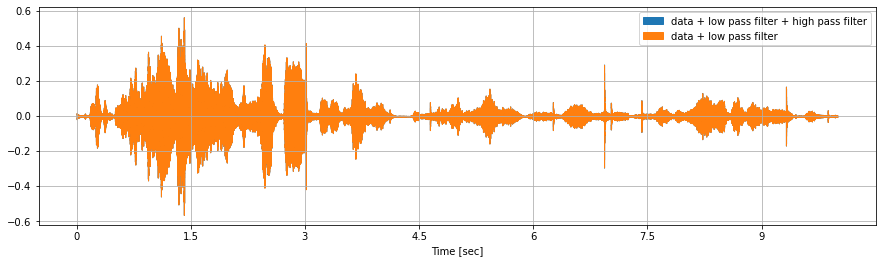

In [20]:
from scipy.signal import filtfilt

# High-pass filter
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

_segment_filtered_2 = butter_highpass_filter(_segment_filtered, 200, fs, order)

plt.figure(figsize=(15, 4))
librosa.display.waveshow(_segment_filtered_2, sr=SAMPLE_RATE, x_axis='time', label='data + low pass filter + high pass filter')
librosa.display.waveshow(_segment_filtered, sr=SAMPLE_RATE, x_axis='time', label='data + low pass filter')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

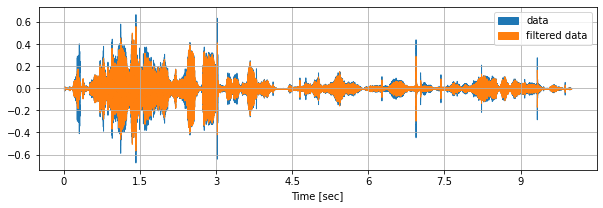

In [21]:
plt.figure(figsize=(10, 3))
librosa.display.waveshow(_segment, sr=SAMPLE_RATE, x_axis='time', label='data')
librosa.display.waveshow(_segment_filtered_2, sr=SAMPLE_RATE, x_axis='time', label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.savefig('../visualization/_segment_filtered.png')
plt.show()

In [22]:
_filtered = butter_lowpass_filter(_, cutoff, fs, order)
_filtered = butter_highpass_filter(_filtered, 200, fs, order)

## Features

### Mel Spectrogram

/tmp/ipykernel_22877/1866207119.py:2: FutureWarning: Pass y=[0.00069259 0.00134584 0.00355326 ... 0.00103498 0.00015923 0.00020733] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  _segment_mel_spectrogram = librosa.feature.melspectrogram(_segment_filtered_2, sr=SAMPLE_RATE)


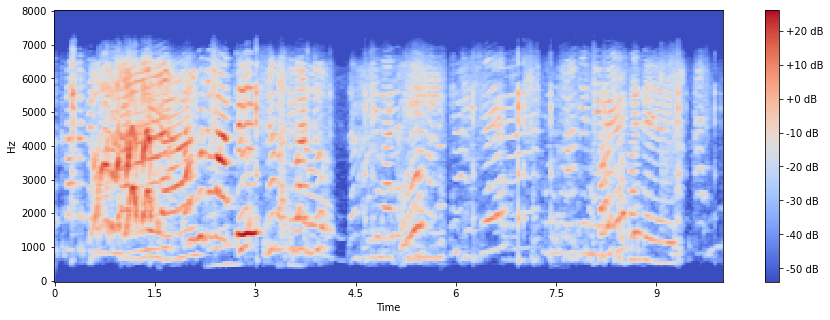

In [23]:
# Audio Mel Spectrogram - raw
_segment_mel_spectrogram = librosa.feature.melspectrogram(_segment_filtered_2, sr=SAMPLE_RATE)
_segment_mel_spectrogram_image = librosa.core.power_to_db(_segment_mel_spectrogram)

plt.figure(figsize=(15, 5))
librosa.display.specshow(_segment_mel_spectrogram_image, sr=SAMPLE_RATE, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.savefig('../visualization/mel_spec.png')
plt.show()

In [24]:
_segment_mel_spectrogram.shape

(128, 313)

In [25]:
(SAMPLE_RATE * 10)

160000

In [26]:
(SAMPLE_RATE * 0.025)

400.0

In [27]:
# FFT window size (25ms)
(SAMPLE_RATE * 10) / (SAMPLE_RATE * 0.025)

400.0

In [28]:
# Stride size (15ms)
(SAMPLE_RATE * 0.015)

240.0

/tmp/ipykernel_22877/1332008340.py:4: FutureWarning: Pass y=[0.00069259 0.00134584 0.00355326 ... 0.00103498 0.00015923 0.00020733] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  _segment_mel_spectrogram = librosa.feature.melspectrogram(_segment_filtered_2, sr=SAMPLE_RATE, n_fft=FRAME_SIZE)


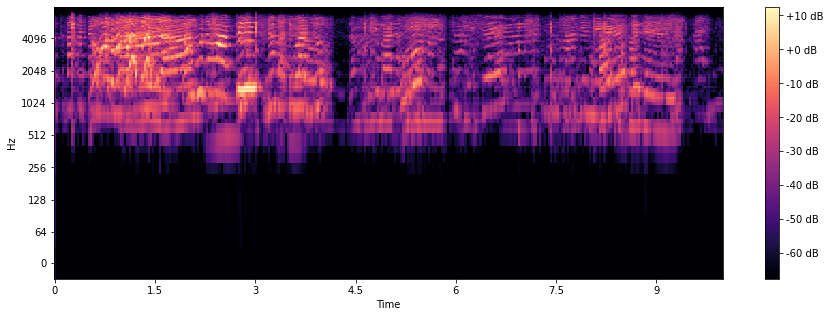

In [29]:
FRAME_SIZE_SECOND = 0.025
FRAME_SIZE = int(SAMPLE_RATE * FRAME_SIZE_SECOND)

_segment_mel_spectrogram = librosa.feature.melspectrogram(_segment_filtered_2, sr=SAMPLE_RATE, n_fft=FRAME_SIZE)
_segment_mel_spectrogram_image = librosa.core.power_to_db(_segment_mel_spectrogram)

plt.figure(figsize=(15, 5))
librosa.display.specshow(_segment_mel_spectrogram_image, sr=SAMPLE_RATE, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.savefig('../visualization/mel_spec_25ms.png')
plt.show()

In [30]:
_segment.shape

(160000,)

In [31]:
_segment.shape[0] / SAMPLE_RATE

10.0

In [32]:
_segment_mel_spectrogram.shape

(128, 313)

240


/tmp/ipykernel_22877/1184742717.py:7: FutureWarning: Pass y=[0.00366144 0.00933674 0.00304715 ... 0.00051035 0.00311605 0.00183265] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  _segment_mel_spectrogram = librosa.feature.melspectrogram(
/home/vin/mambaforge/lib/python3.9/site-packages/librosa/core/spectrum.py:1592: RuntimeWarning: divide by zero encountered in log10
  log_spec = 10.0 * np.log10(np.maximum(amin, magnitude))


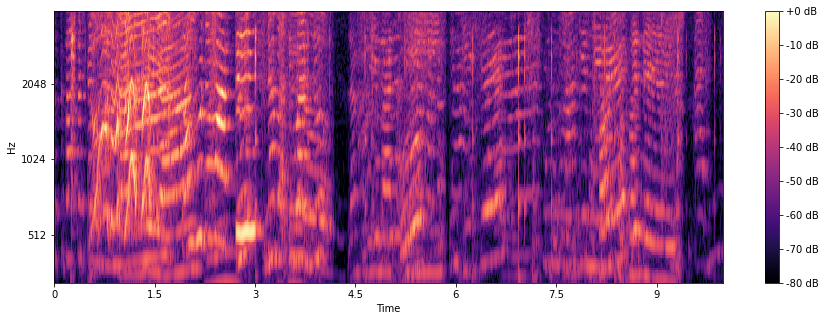

In [33]:
FRAME_STRIDE_SECOND = 0.015
FRAME_STRIDE = int(SAMPLE_RATE * FRAME_STRIDE_SECOND)
print(FRAME_STRIDE)

MEL_AMOUNT = 128

_segment_mel_spectrogram = librosa.feature.melspectrogram(
    _segment,
    sr=SAMPLE_RATE,
    win_length=FRAME_SIZE,
    hop_length=FRAME_STRIDE,
    n_mels=MEL_AMOUNT,
    fmin=200,
    fmax=4000,
    dtype=np.float16
).astype(np.float16)
_segment_mel_spectrogram_image = librosa.core.power_to_db(_segment_mel_spectrogram, ref=np.max)

plt.figure(figsize=(15, 5))
librosa.display.specshow(_segment_mel_spectrogram_image, sr=SAMPLE_RATE, hop_length=FRAME_STRIDE, x_axis='time', y_axis='mel', fmin=200, fmax=4000)
plt.colorbar(format='%+2.0f dB')

plt.savefig('../visualization/mel_spec_25ms_stride15ms.svg')
plt.show()

In [34]:
_segment_mel_spectrogram.dtype

dtype('float16')

In [35]:
from pympler.asizeof import asizeof
print(f"Size: {asizeof(_segment_mel_spectrogram) / 1e3} KB")

Size: 170.888 KB


In [36]:
_segment_mel_spectrogram.shape

(128, 667)

/tmp/ipykernel_22877/4157260741.py:1: FutureWarning: Pass y=[ 0.0026103  -0.00595774  0.00753117 ... -0.00021945  0.00035524
 -0.00209893] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  _mel_spectrogram = librosa.feature.melspectrogram(


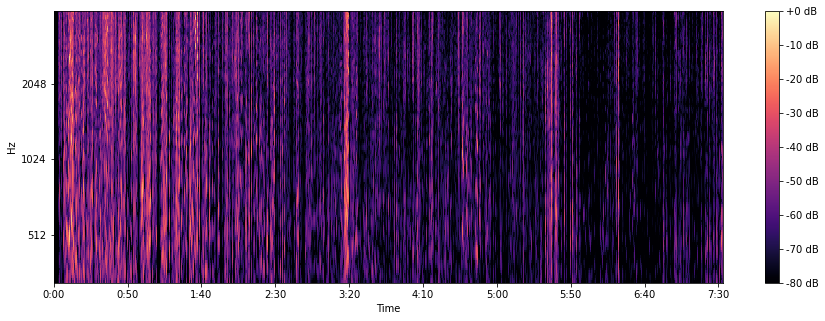

In [37]:
_mel_spectrogram = librosa.feature.melspectrogram(
    _,
    sr=SAMPLE_RATE,
    win_length=FRAME_SIZE,
    hop_length=FRAME_STRIDE,
    n_mels=MEL_AMOUNT,
    fmin=200,
    fmax=4000,
    dtype=np.float16
).astype(np.float16)

plt.figure(figsize=(15, 5))
librosa.display.specshow(librosa.core.power_to_db(_mel_spectrogram, ref=np.max), sr=SAMPLE_RATE, hop_length=266, x_axis='time', y_axis='mel', fmin=200, fmax=4000)
plt.colorbar(format='%+2.0f dB')

plt.show()

In [38]:
_mel_spectrogram.shape

(128, 27264)

### Frequency Spectrogram

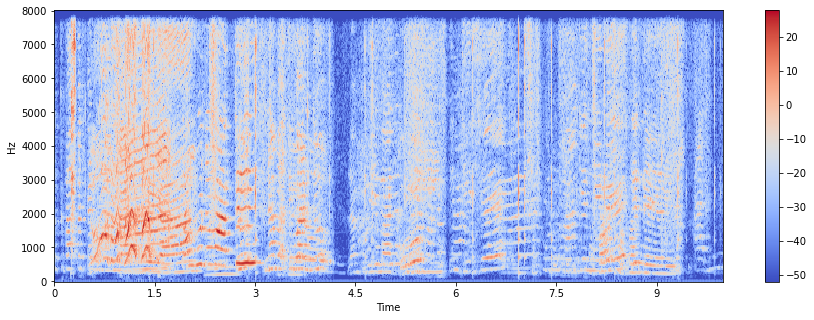

In [39]:
# Spectrogram
win_length = 256

_segment_spectrogram = librosa.core.stft(_segment, n_fft=FRAME_SIZE, hop_length=FRAME_STRIDE)
_segment_spectrogram_db = librosa.amplitude_to_db(abs(_segment_spectrogram))

plt.figure(figsize=(15, 5))
librosa.display.specshow(_segment_spectrogram_db, sr=SAMPLE_RATE, hop_length=FRAME_STRIDE, x_axis='time', y_axis='hz')
plt.colorbar()

plt.savefig('../visualization/spec.png')
plt.show()

In [40]:
_segment_spectrogram.shape

(201, 667)

(190, 667)


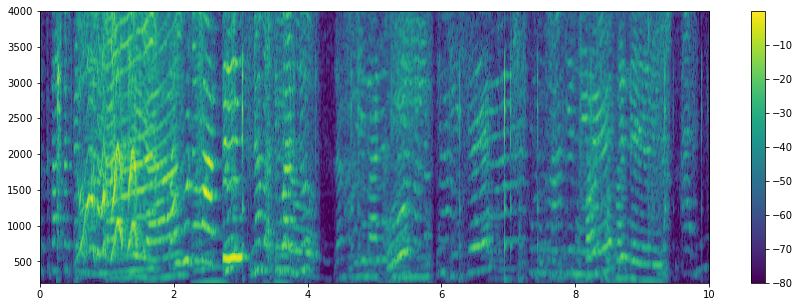

In [41]:
LOWER_BOUND = 200 // 20
UPPER_BOUND = 4000 // 20

_segment_spectrogram = np.abs(
    librosa.core.stft(
        _segment,
        win_length=FRAME_SIZE,
        hop_length=FRAME_STRIDE,
        n_fft=800
    )
)[LOWER_BOUND:UPPER_BOUND, :].astype(np.float16)
_segment_spectrogram_db = librosa.amplitude_to_db(_segment_spectrogram, ref=np.max)

print(_segment_spectrogram.shape)

plt.figure(figsize=(15, 5))
# librosa.display.specshow(_segment_spectrogram_db, sr=SAMPLE_RATE, hop_length=FRAME_STRIDE, x_axis='time', y_axis='hz')
plt.imshow(_segment_spectrogram_db, aspect='auto', origin='lower', extent=[0, 10, 200, 4000], cmap='viridis')
# plt.specgram(_segment_spectrogram_db, Fs=SAMPLE_RATE, NFFT=380, xextent=[200, 4000])
plt.colorbar()
plt.savefig('../visualization/spec_stft.png')
plt.show()

In [42]:
_segment_spectrogram.dtype

dtype('float16')

### Spectrogram (log-adjusted)

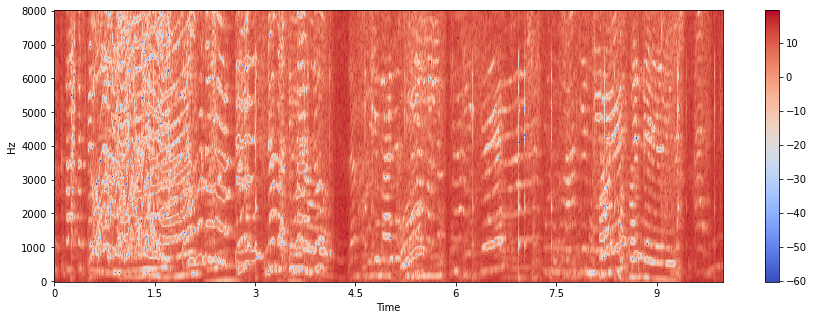

In [43]:
# Spectrogram - log-adjusted
import numpy as np

# _spectrogram_log_db = cp.log(cp.abs(cp.asarray(_spectrogram)))
# _spectrogram_log = librosa.core.stft(_segment, n_fft=256, win_length=win_length, hop_length=hop)
# _spectrogram_log_db = librosa.amplitude_to_db(cp.log(cp.abs(cp.asarray(_spectrogram))).get())
_segment_spectrogram_log_db = librosa.amplitude_to_db(np.log(np.abs(_segment_spectrogram)))

plt.figure(figsize=(15, 5))
librosa.display.specshow(_segment_spectrogram_log_db, sr=SAMPLE_RATE, hop_length=FRAME_STRIDE, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()

### Comparison

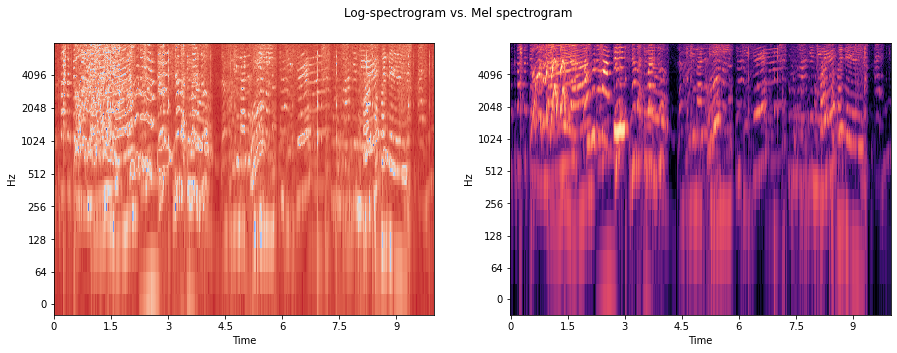

In [44]:
# Log spectrogram vs. Mel spectrogram
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Log-spectrogram vs. Mel spectrogram')
librosa.display.specshow(_segment_spectrogram_log_db, sr=SAMPLE_RATE, x_axis='time', y_axis='log', hop_length=FRAME_STRIDE, ax=ax[0])
librosa.display.specshow(_segment_mel_spectrogram_image, sr=SAMPLE_RATE, hop_length=FRAME_STRIDE, x_axis='time', y_axis='log', ax=ax[1])
plt.savefig('../visualization/comparison_log_mel_spec.png')
plt.show()

## Mel Frequency Cepstrum Coefficient

/tmp/ipykernel_22877/3294931450.py:1: FutureWarning: Pass y=[0.00366144 0.00933674 0.00304715 ... 0.00051035 0.00311605 0.00183265] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  _segment_mfcc = librosa.feature.mfcc(_segment, sr=SAMPLE_RATE)


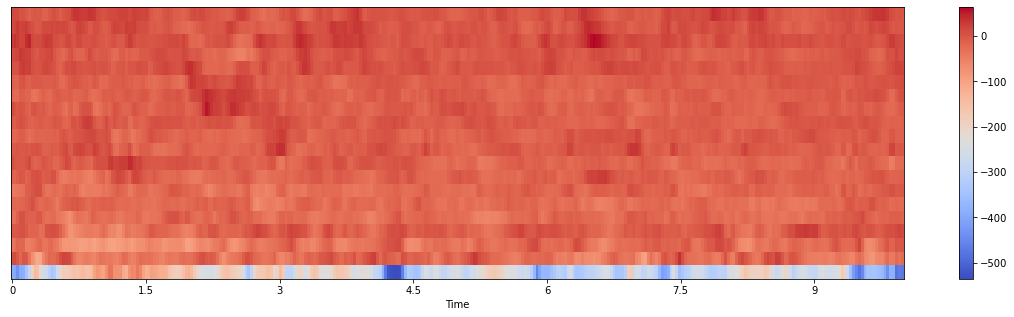

In [45]:
_segment_mfcc = librosa.feature.mfcc(_segment, sr=SAMPLE_RATE)

plt.figure(figsize=(20, 5))
librosa.display.specshow(_segment_mfcc, sr=SAMPLE_RATE, x_axis='time')
plt.colorbar()

plt.savefig('../visualization/mfcc.png')
plt.show()

In [46]:
_segment_mfcc.shape

(20, 313)

/tmp/ipykernel_22877/3412980727.py:1: FutureWarning: Pass y=[0.00366144 0.00933674 0.00304715 ... 0.00051035 0.00311605 0.00183265] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  _segment_mfcc = librosa.feature.mfcc(_segment, sr=SAMPLE_RATE, win_length=FRAME_SIZE, n_mfcc=40, hop_length=FRAME_STRIDE)


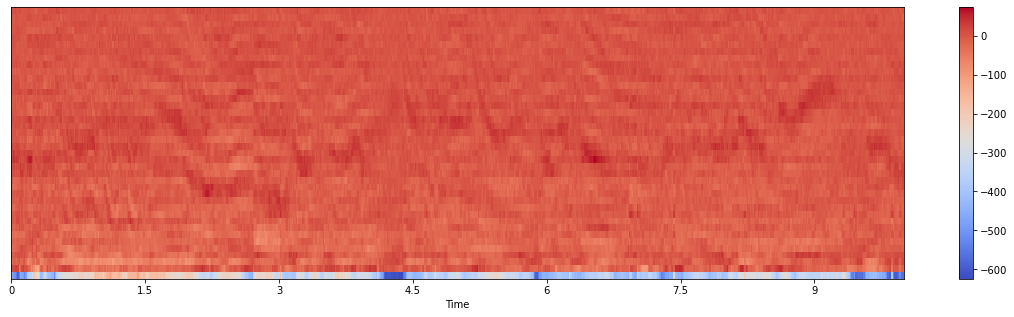

In [47]:
_segment_mfcc = librosa.feature.mfcc(_segment, sr=SAMPLE_RATE, win_length=FRAME_SIZE, n_mfcc=40, hop_length=FRAME_STRIDE)

plt.figure(figsize=(20, 5))
librosa.display.specshow(_segment_mfcc, sr=SAMPLE_RATE, x_axis='time', hop_length=FRAME_STRIDE)
plt.colorbar()

plt.savefig('../visualization/mfcc-40.png')
plt.show()

In [48]:
_segment_mfcc.shape

(40, 667)

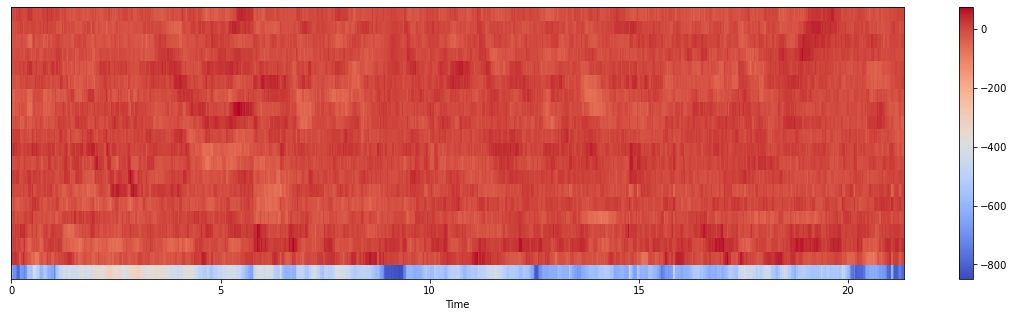

In [49]:
# MFCC from Mel spectrogram

_segment_mfcc_from_mel_spectrogram = librosa.feature.mfcc(S=_segment_mel_spectrogram_image)

plt.figure(figsize=(20, 5))
librosa.display.specshow(_segment_mfcc_from_mel_spectrogram, sr=SAMPLE_RATE, x_axis='time')
plt.colorbar()

plt.savefig('../visualization/mfcc_from_spectrogram.png')
plt.show()

/tmp/ipykernel_22877/1316006314.py:1: FutureWarning: Pass y=[ 1.59084740e-05  1.67276569e-04  8.60509226e-05 ... -1.20224386e-04
 -4.04800252e-06  2.14419802e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  _mfcc = librosa.feature.mfcc(_filtered, sr=SAMPLE_RATE, n_fft=FRAME_SIZE, n_mfcc=40, hop_length=FRAME_STRIDE)


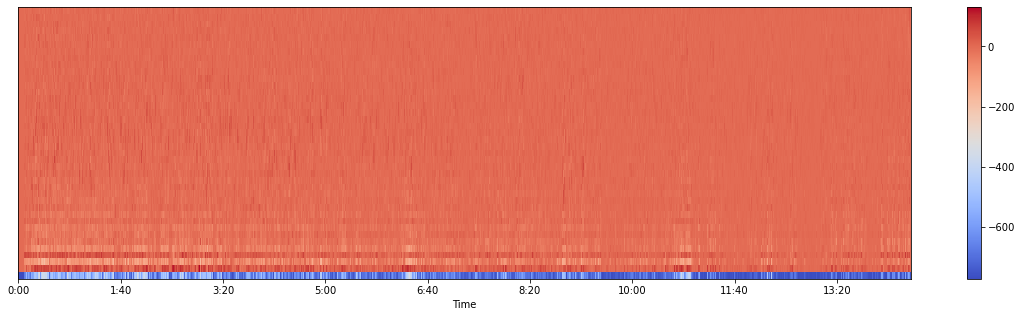

In [50]:
_mfcc = librosa.feature.mfcc(_filtered, sr=SAMPLE_RATE, n_fft=FRAME_SIZE, n_mfcc=40, hop_length=FRAME_STRIDE)

plt.figure(figsize=(20, 5))
librosa.display.specshow(_mfcc, sr=SAMPLE_RATE, x_axis='time')
plt.colorbar()
plt.show()

### Functions

In [52]:
# Windowing and Gating

# def filter_noise(wave):
#     _rms = librosa.feature.rms(wave, frame_length=400, hop_length=wave.shape[0] // IMAGE_WIDTH)
#     _threshold = np.mean(_rms) / 2 * 1.04
#     _mask = np.nonzero(_rms > _threshold)[1]
#     return wave[:, _mask]

def split_second(wave, second=10, sr=SAMPLE_RATE):
    wave_windows = list()
    l = 0
    r = second * sr
    while r < wave.shape[0]:
        wave_windows.append(wave[l:r])
        print(l, r, r/sr)
        l += second * sr
        r = r + second * sr if r + second * sr < wave.shape[0] else wave.shape[0]
    wave_windows.append(wave[l:r])
    print('Done at', l, r)
    return wave_windows

def desilence(wave, feature):
    _rms = librosa.feature.rms(wave, frame_length=400)
    _threshold = np.mean(_rms) / 2 * 1.04
    _mask = np.nonzero(_rms > _threshold)[1]

    return feature[:, _mask]

In [53]:
_split = split_second(_)

0 160000 10.0
160000 320000 20.0
320000 480000 30.0
480000 640000 40.0
640000 800000 50.0
800000 960000 60.0
960000 1120000 70.0
1120000 1280000 80.0
1280000 1440000 90.0
1440000 1600000 100.0
1600000 1760000 110.0
1760000 1920000 120.0
1920000 2080000 130.0
2080000 2240000 140.0
2240000 2400000 150.0
2400000 2560000 160.0
2560000 2720000 170.0
2720000 2880000 180.0
2880000 3040000 190.0
3040000 3200000 200.0
3200000 3360000 210.0
3360000 3520000 220.0
3520000 3680000 230.0
3680000 3840000 240.0
3840000 4000000 250.0
4000000 4160000 260.0
4160000 4320000 270.0
4320000 4480000 280.0
4480000 4640000 290.0
4640000 4800000 300.0
4800000 4960000 310.0
4960000 5120000 320.0
5120000 5280000 330.0
5280000 5440000 340.0
5440000 5600000 350.0
5600000 5760000 360.0
5760000 5920000 370.0
5920000 6080000 380.0
6080000 6240000 390.0
6240000 6400000 400.0
Done at 6400000 6543237


/tmp/ipykernel_22877/1459356383.py:1: FutureWarning: Pass y=[ 0.0026103  -0.00595774  0.00753117 ... -0.00021945  0.00035524
 -0.00209893] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  _mel_spectrogram = librosa.feature.melspectrogram(_, sr=SAMPLE_RATE, n_fft=400, fmin=200, fmax=4000)
/home/vin/mambaforge/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


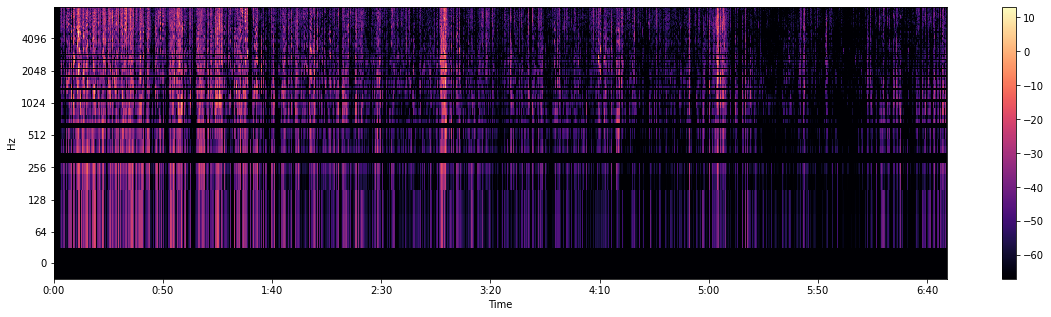

In [54]:
_mel_spectrogram = librosa.feature.melspectrogram(_, sr=SAMPLE_RATE, n_fft=400, fmin=200, fmax=4000)

plt.figure(figsize=(20, 5))
librosa.display.specshow(librosa.core.power_to_db(_mel_spectrogram), sr=SAMPLE_RATE, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

In [55]:
_mel_spectrogram.shape

(128, 12780)

In [56]:
_desilenced = desilence(_, _mel_spectrogram)
_desilenced.shape

/tmp/ipykernel_22877/3575065510.py:23: FutureWarning: Pass y=[ 0.0026103  -0.00595774  0.00753117 ... -0.00021945  0.00035524
 -0.00209893] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  _rms = librosa.feature.rms(wave, frame_length=400)


(128, 3906)

In [57]:
_mel_spectrogram.shape

(128, 12780)

/tmp/ipykernel_22877/675286752.py:2: FutureWarning: Pass y=[ 0.0026103  -0.00595774  0.00753117 ... -0.00021945  0.00035524
 -0.00209893] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  _mfcc = librosa.feature.mfcc(_, sr=SAMPLE_RATE, n_mfcc=40, n_fft=400, fmin=200, fmax=4000)


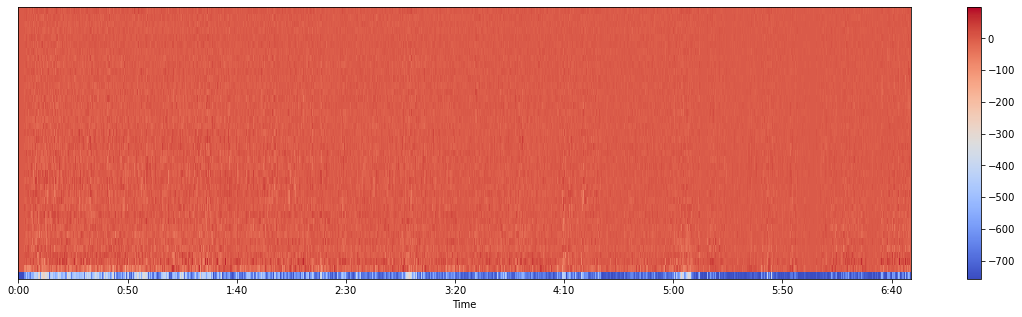

In [58]:
# MFCC - Full
_mfcc = librosa.feature.mfcc(_, sr=SAMPLE_RATE, n_mfcc=40, n_fft=400, fmin=200, fmax=4000)

plt.figure(figsize=(20, 5))
librosa.display.specshow(_mfcc, sr=SAMPLE_RATE, x_axis='time')

plt.colorbar()
plt.show()

In [59]:
_mfcc.shape

(40, 12780)

/tmp/ipykernel_22877/3575065510.py:23: FutureWarning: Pass y=[ 0.0026103  -0.00595774  0.00753117 ... -0.00021945  0.00035524
 -0.00209893] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  _rms = librosa.feature.rms(wave, frame_length=400)


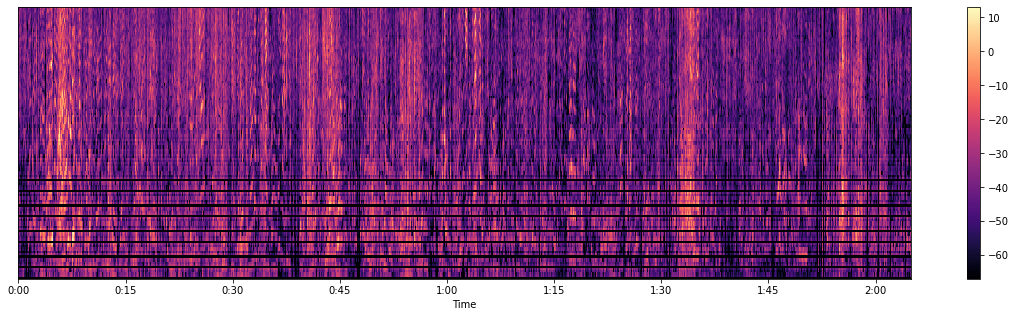

In [60]:
# Voice Activity Detection on full WAV
_mel_spectrogram_desilenced = desilence(_, _mel_spectrogram)

plt.figure(figsize=(20, 5))
librosa.display.specshow(librosa.core.power_to_db(_mel_spectrogram_desilenced), sr=SAMPLE_RATE, x_axis='time')

plt.colorbar()
plt.show()

In [61]:
_mel_spectrogram_desilenced.shape

(128, 3906)

In [62]:
# Saving test
np.savetxt('../dataset/mel_spectrogram_test', _mel_spectrogram)

In [63]:
_load_file_test = np.loadtxt('../dataset/mel_spectrogram_test')

In [64]:
_load_file_test.shape

(128, 12780)

In [65]:
_mel_spectrogram.dtype

dtype('float32')

In [66]:
_mel_spectrogram.shape

(128, 12780)

In [67]:
# Testing the Cepstral Mean Variance Normalisation function and visualising the result
from medhok import preprocessing as pre
# import math

# threads_per_block=256
# blocks_per_grid=math.ceil(_segment_mel_spectrogram.shape[1] / threads_per_block)
_segment_mel_spectrogram_normalised = pre.normalise_feature(_segment_mel_spectrogram)

plt.figure(figsize=(15, 5))
librosa.display.specshow(_segment_mel_spectrogram_normalised, sr=SAMPLE_RATE, x_axis='time', hop_length=HOP_LENGTH)
plt.colorbar()

plt.show()

ImportError: cannot import name 'constants' from 'medhok' (unknown location)

In [68]:
_segment_mel_spectrogram[:, 0]

array([3.1710e-05, 3.2365e-05, 3.3438e-05, 5.2512e-05, 1.1945e-04,
       2.5511e-04, 4.5609e-04, 6.8569e-04, 8.8215e-04, 9.8705e-04,
       9.8991e-04, 8.3065e-04, 6.5231e-04, 4.9114e-04, 3.8910e-04,
       3.5143e-04, 3.5620e-04, 3.7932e-04, 4.1699e-04, 4.6730e-04,
       5.8413e-04, 7.7438e-04, 1.0309e-03, 1.3285e-03, 1.6499e-03,
       2.0161e-03, 2.4109e-03, 2.7275e-03, 2.9888e-03, 3.0556e-03,
       2.8439e-03, 2.3632e-03, 1.7166e-03, 1.0805e-03, 5.7650e-04,
       3.0065e-04, 2.0921e-04, 1.9491e-04, 1.8013e-04, 1.3959e-04,
       9.3699e-05, 7.4685e-05, 9.0480e-05, 1.2910e-04, 1.7560e-04,
       2.3055e-04, 3.0828e-04, 4.1699e-04, 5.7125e-04, 6.8665e-04,
       7.3338e-04, 7.2145e-04, 6.1703e-04, 4.4107e-04, 3.1042e-04,
       1.6689e-04, 9.5606e-05, 4.5180e-05, 2.4617e-05, 1.4961e-05,
       1.4544e-05, 2.6047e-05, 4.5657e-05, 5.7697e-05, 5.3346e-05,
       7.7903e-05, 2.0516e-04, 4.3726e-04, 6.1655e-04, 5.4598e-04,
       2.7633e-04, 9.9599e-05, 3.1376e-04, 8.7500e-04, 1.5526e

In [69]:
print(_segment_mel_spectrogram_normalised[:, 0].max())
print(_segment_mel_spectrogram_normalised[:, 0].min())
print(_segment_mel_spectrogram_normalised[:, 0].mean())
print(_segment_mel_spectrogram_normalised[:, 0].std())

NameError: name '_segment_mel_spectrogram_normalised' is not defined

NameError: name 'HOP_LENGTH' is not defined

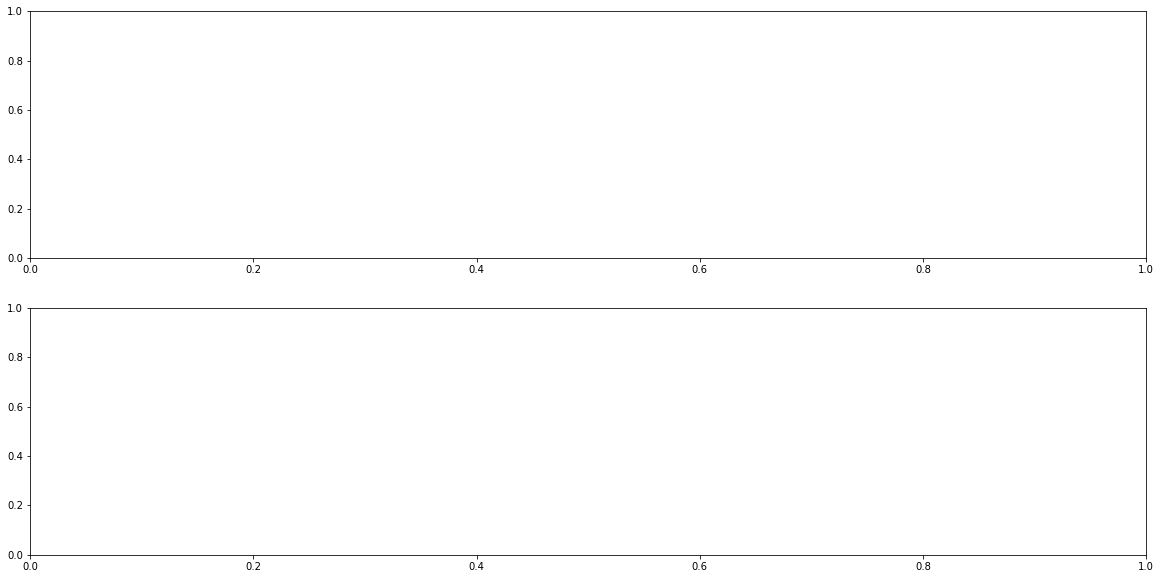

In [70]:
# Side-by-side comparison of Pure Mel Spectrogram and Normalised Mel Spectrogram, as shown in two figures

fig, ax = plt.subplots(2, figsize=(20, 10))

feat_ax = librosa.display.specshow(librosa.core.power_to_db(_segment_mel_spectrogram), sr=SAMPLE_RATE, x_axis='time', hop_length=HOP_LENGTH, ax=ax[0])
feat_norm_ax = librosa.display.specshow(_segment_mel_spectrogram_normalised, sr=SAMPLE_RATE, x_axis='time', hop_length=HOP_LENGTH, ax=ax[1])

plt.colorbar(feat_norm_ax, ax=ax)

plt.show()

## Mel Filter Bank

In [73]:
FRAME_SIZE = int(0.025 * SAMPLE_RATE)

mel_fb = librosa.filters.mel(sr=SAMPLE_RATE, n_mels=MEL_AMOUNT, n_fft=FRAME_SIZE)
mel_fb.shape

(128, 201)

In [74]:
mel_fb

array([[0.        , 0.01237399, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03039256, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02474797, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00222856, 0.00111428,
        0.        ]], dtype=float32)